# **Install & Import Libraries**
Install required libraries

Import essential packages for QA development

In [1]:
#  Install necessary packages (quietly to avoid clutter)
!pip install -q transformers datasets scikit-learn pandas tqdm
!pip install transformers datasets --quiet
#  Import core Python & ML libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForQuestionAnswering
from datasets import load_dataset

#  Utility libraries
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm #Python library for displaying smart progress bars in loops

#  Check GPU
#Dynamically selects between GPU and CPU, so your code works efficiently and flexibly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

# **Load & Inspect SQuAD 2.0 Dataset**
Load the dataset from Hugging Face's datasets library

View structure and sample records

Understand how to handle unanswerable questions (which you wisely pointed out earlier)



In [2]:
#Load the SQuAD 2.0 dataset (train and validation splits)
squad_dataset = load_dataset("squad_v2")

#Convert to DataFrame for easier inspection
df_train = pd.DataFrame(squad_dataset['train'])
df_valid = pd.DataFrame(squad_dataset['validation'])

# View shape and sample records
print("Dataset loaded successfully!")
print(f"Train samples: {len(df_train)}, Validation samples: {len(df_valid)}")
display(df_train.head(2))  # Display first 2 records for clarity
print(df_train.info())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset loaded successfully!
Train samples: 130319, Validation samples: 11873


,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130319 entries, 0 to 130318
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        130319 non-null  object
 1   title     130319 non-null  object
 2   context   130319 non-null  object
 3   question  130319 non-null  object
 4   answers   130319 non-null  object
dtypes: object(5)
memory usage: 5.0+ MB
None


# **Data Preprocessing for SQuAD 2.0**
Extract the clean answer text (or "No answer" if empty)

Set answer start and end positions (in character indices)

Create the is_impossible flag

Prepare these fields as new columns in the DataFrame

In [3]:
# 🔧 Step 1: Define a function to extract clean fields
def preprocess_squad_df(df):
    clean_answers = []
    start_positions = []
    end_positions = []
    impossible_flags = []

    for idx, row in df.iterrows():
        answers = row['answers']

        if answers['text']:
            clean_answer = answers['text'][0]
            start = answers['answer_start'][0]
            end = start + len(clean_answer)
            is_impossible = False
        else:
            clean_answer = "No answer"
            start = 0
            end = 0
            is_impossible = True

        clean_answers.append(clean_answer)
        start_positions.append(start)
        end_positions.append(end)
        impossible_flags.append(is_impossible)

    df['clean_answer'] = clean_answers
    df['answer_start'] = start_positions
    df['answer_end'] = end_positions
    df['is_impossible'] = impossible_flags

    return df

'''# ✅ Step 2: Apply to both train and validation datasets
df_train = pd.DataFrame(squad_dataset['train'])
df_valid = pd.DataFrame(squad_dataset['validation'])'''

df_train = preprocess_squad_df(df_train)
df_valid = preprocess_squad_df(df_valid)

# 🔍 Step 3: Inspect the new structure
df_train[['context','question', 'clean_answer', 'answer_start', 'answer_end', 'is_impossible']].head(10)


,context,question,clean_answer,answer_start,answer_end,is_impossible
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,286,False
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,226,False
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,530,False
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,180,False
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,286,False
5,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what R&B group was she the lead singer?,Destiny's Child,320,335,False
6,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What album made her a worldwide known artist?,Dangerously in Love,505,524,False
7,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,Who managed the Destiny's Child group?,Mathew Knowles,360,374,False
8,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyoncé rise to fame?,late 1990s,276,286,False
9,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What role did Beyoncé have in Destiny's Child?,lead singer,290,301,False


# **Exploratory Data Analysis (EDA)**
Answerable vs. Unanswerable Distribution

Sequence Length Stats (Max, 95th Percentile

Visuals:

Question length distribution

Context word count distribution

Questions per article title

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<ipython-input-4-495dcf716f20>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=answerable_counts.index.map({True: 'Answerable', False: 'Unanswerable'}),


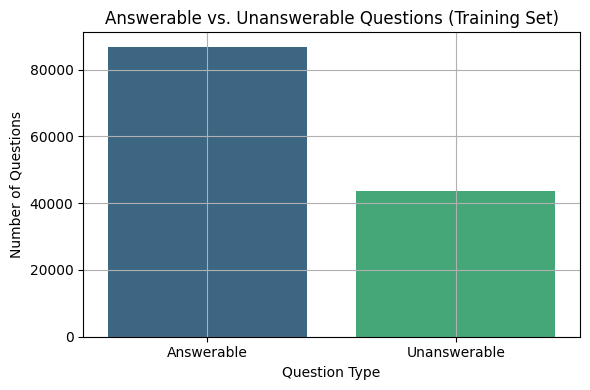

✅ Answerable distribution:
answerable
True     86821
False    43498
Name: count, dtype: int64


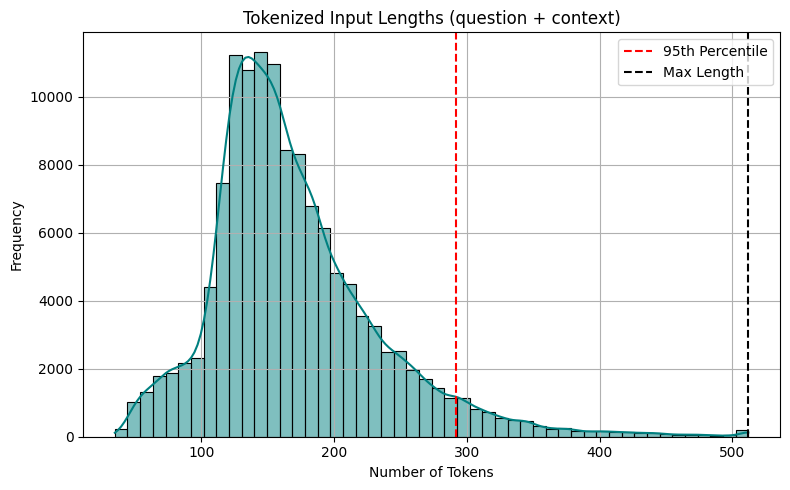

📊 Max input length: 512
📊 95th percentile length: 292


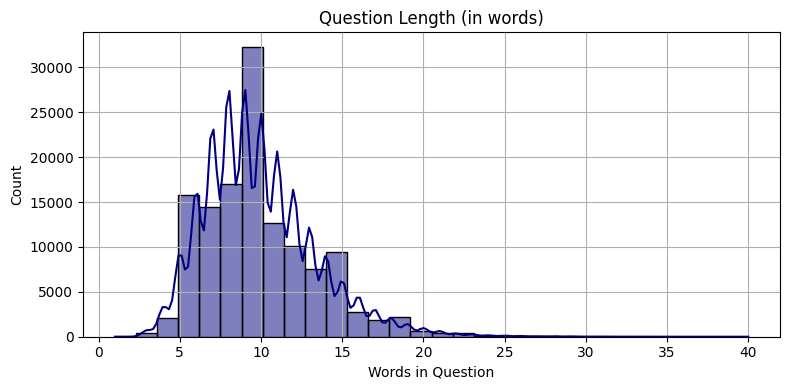

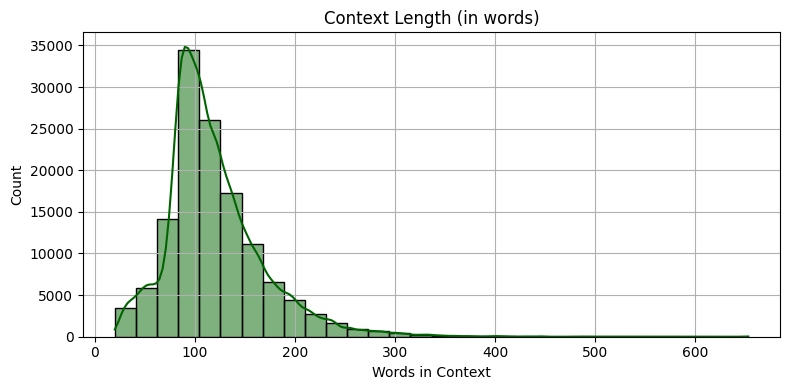

<ipython-input-4-495dcf716f20>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=title_counts.index, x=title_counts.values, palette="crest")


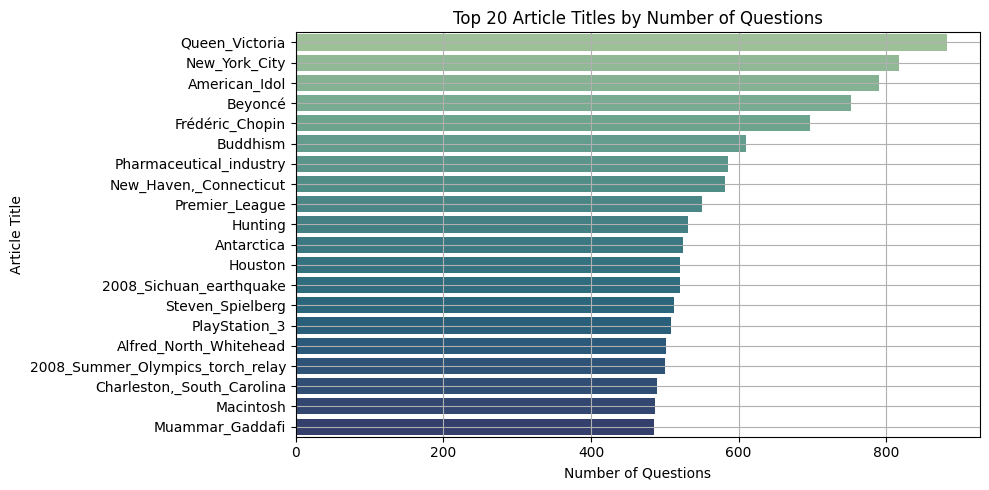

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizerFast

# Use Fast tokenizer for accurate token alignment
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# =====================
# 📊 2B.1 - Answerable vs. Unanswerable
# =====================
df_train['answerable'] = ~df_train['is_impossible']
answerable_counts = df_train['answerable'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=answerable_counts.index.map({True: 'Answerable', False: 'Unanswerable'}),
            y=answerable_counts.values, palette="viridis")
plt.title("Answerable vs. Unanswerable Questions (Training Set)")
plt.ylabel("Number of Questions")
plt.xlabel("Question Type")
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Answerable distribution:")
print(answerable_counts)

# =====================
# 📏 2B.2 - Sequence Length Distribution
# =====================
# Compute input lengths after tokenizing (question + context)
def compute_input_length(row):
    encoded = tokenizer(
        row['question'], row['context'],
        truncation=True, max_length=512, padding=False,
        return_tensors=None
    )
    return len(encoded['input_ids'])

df_train['input_length'] = df_train.apply(compute_input_length, axis=1)

# Plot histogram of input lengths
plt.figure(figsize=(8, 5))
sns.histplot(df_train['input_length'], bins=50, kde=True, color='teal')
plt.axvline(df_train['input_length'].quantile(0.95), color='red', linestyle='--', label='95th Percentile')
plt.axvline(df_train['input_length'].max(), color='black', linestyle='--', label='Max Length')
plt.title("Tokenized Input Lengths (question + context)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

print("📊 Max input length:", df_train['input_length'].max())
print("📊 95th percentile length:", int(df_train['input_length'].quantile(0.95)))

# =====================
# 🧠 2B.3 - Optional Visuals
# =====================

# (a) Question length
df_train['question_length'] = df_train['question'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 4))
sns.histplot(df_train['question_length'], bins=30, kde=True, color='navy')
plt.title("Question Length (in words)")
plt.xlabel("Words in Question")
plt.tight_layout()
plt.grid(True)
plt.show()

# (b) Context length
df_train['context_length'] = df_train['context'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 4))
sns.histplot(df_train['context_length'], bins=30, kde=True, color='darkgreen')
plt.title("Context Length (in words)")
plt.xlabel("Words in Context")
plt.tight_layout()
plt.grid(True)
plt.show()

# (c) Questions per Article Title
title_counts = df_train['title'].value_counts().head(20)
plt.figure(figsize=(10, 5))
sns.barplot(y=title_counts.index, x=title_counts.values, palette="crest")
plt.title("Top 20 Article Titles by Number of Questions")
plt.xlabel("Number of Questions")
plt.ylabel("Article Title")
plt.tight_layout()
plt.grid(True)
plt.show()


# **Tokenize and Align QA Data**
Tokenize each (question, context) pair using BertTokenizerFast

Convert answer_start (character index) to token-level indices

Handle special cases (unanswerable questions with "No answer")

In [5]:
from transformers import BertTokenizerFast

# Load fast tokenizer (already done before, but repeating just in case)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Function to tokenize and align start/end positions
def tokenize_and_align(df, tokenizer, max_length=384):
    input_ids = []
    attention_masks = []
    start_positions = []
    end_positions = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Tokenizing"):
        question = row['question']
        context = row['context']
        answer_text = row['clean_answer']
        answer_start_char = row['answer_start']
        answer_end_char = row['answer_end']
        is_impossible = row['is_impossible']

        # Tokenize with offset mapping
        encoding = tokenizer(
            question,
            context,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_offsets_mapping=True,
            return_tensors="pt"
        )

        offsets = encoding['offset_mapping'][0]
        input_id = encoding['input_ids'][0]
        attention_mask = encoding['attention_mask'][0]

        # Default positions for unanswerable questions
        start_pos = 0
        end_pos = 0

        if not is_impossible:
            # Find the start/end token indices within the context
            for i, (start, end) in enumerate(offsets):
                if start <= answer_start_char < end:
                    start_pos = i
                if start < answer_end_char <= end:
                    end_pos = i
                    break
            # If no match found, fallback to 0
            if start_pos == 0 and end_pos == 0:
                start_pos = 0
                end_pos = 0

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        start_positions.append(start_pos)
        end_positions.append(end_pos)

    return {
        "input_ids": torch.stack(input_ids),
        "attention_mask": torch.stack(attention_masks),
        "start_positions": torch.tensor(start_positions),
        "end_positions": torch.tensor(end_positions)
    }

# Apply to both training and validation datasets
train_encodings = tokenize_and_align(df_train, tokenizer)
valid_encodings = tokenize_and_align(df_valid, tokenizer)

print("✅ Tokenization complete.")
# % of rows exeeding max length =384 tokens
print("% of number rows exeding the chosen no max tokens: ",(df_train['input_length'] > 384).mean())

Tokenizing:   0%|          | 0/130319 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/11873 [00:00<?, ?it/s]

✅ Tokenization complete.
% of number rows exeding the chosen no max tokens:  0.010535685510171195


# **Create QADataset and DataLoader**
Wrap train_encodings and valid_encodings in a PyTorch-compatible dataset class

Enable batch loading using DataLoader

Ready the data for use in training and evaluation loops

In [6]:
from torch.utils.data import Dataset, DataLoader

# 🔧 Define custom dataset class
class QADataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'start_positions': self.encodings['start_positions'][idx],
            'end_positions': self.encodings['end_positions'][idx]
        }

# ✅ Create dataset objects
train_dataset = QADataset(train_encodings)
valid_dataset = QADataset(valid_encodings)

# 🔃 Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# ✅ Test: Check one sample
sample = train_dataset[0]
print("Sample input_ids shape:", sample['input_ids'].shape)
print("Start token index:", sample['start_positions'])
print("End token index:", sample['end_positions'])


Sample input_ids shape: torch.Size([384])
Start token index: tensor(75)
End token index: tensor(78)


# **BERT Model Setup and Optimizer Configuration**
Load a pretrained BERT model for question answering

Move the model to the correct device (GPU/CPU)

Define the loss function and optimizer

In [ ]:
from transformers import BertForQuestionAnswering
from torch.optim import AdamW  # ⬅️ Fixed import

# ✅ Load BERT QA model
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

# 🔁 Move model to device (GPU if available)
model.to(device)
print(f"✅ Model loaded and moved to: {device}")

# 🧠 Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# 📌 Sanity check
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded and moved to: cuda
Number of trainable parameters: 108,893,186


# **Training Loop for Question Answering**
Define the training process

Track training loss over epochs

Print or plot progress using tqdm

(Optionally) support early stopping and save loss history



Epoch 1:   0%|          | 0/8145 [00:00<?, ?it/s]

✅ Epoch 1 complete. Average loss: 1.5618


Epoch 2:   0%|          | 0/8145 [00:00<?, ?it/s]

✅ Epoch 2 complete. Average loss: 0.9925


Epoch 3:   0%|          | 0/8145 [00:00<?, ?it/s]

✅ Epoch 3 complete. Average loss: 0.7387


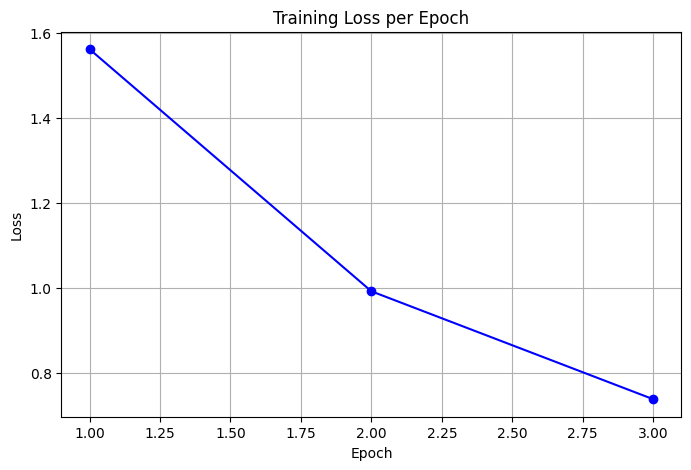

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# ✅ Training function
def train_qa_model(model, train_loader, optimizer, epochs=3):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        for batch in loop:
            # Move to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            # Forward pass with labels (model returns loss automatically)
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            start_positions=start_positions,
                            end_positions=end_positions)

            loss = outputs.loss
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"✅ Epoch {epoch+1} complete. Average loss: {avg_loss:.4f}")

    return loss_history

# ⏳ Train the model
epochs = 3  # You can increase if needed
loss_history = train_qa_model(model, train_loader, optimizer, epochs=epochs)

# 📈 Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='-', color='blue')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


# **Save the Trained Model and Tokenizer**
Save the trained model weights

Save the tokenizer with its configuration

Optionally, store both on Google Drive for safe access and future inference

In [ ]:
import os
from transformers import BertForQuestionAnswering

# 🔧 Set folder path to save locally
model_dir = "/content/qa_model_checkpoint"
os.makedirs(model_dir, exist_ok=True)

# ✅ Save model
model.save_pretrained(model_dir)

# ✅ Save tokenizer
tokenizer.save_pretrained(model_dir)

print(f"✅ Model and tokenizer saved to: {model_dir}")


✅ Model and tokenizer saved to: /content/qa_model_checkpoint


**Save to Google Drive**

In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Set destination folder in Drive
drive_folder = "/content/drive/My Drive/SQuAD_QA_Model"
os.makedirs(drive_folder, exist_ok=True)

# Copy saved model and tokenizer to Drive
shutil.copytree(model_dir, drive_folder, dirs_exist_ok=True)

print(f"✅ Model and tokenizer copied to Google Drive at: {drive_folder}")


Mounted at /content/drive
✅ Model and tokenizer copied to Google Drive at: /content/drive/My Drive/SQuAD_QA_Model


# **Reload the Trained Model Reload the Tokenizer**

Option 1: Trained model form Google Colab

Requires the Folder "qa_model_checkpoint" manually creted in the Colab session and all the files should be downloaded in that folder before running this code

In [ ]:
from transformers import BertForQuestionAnswering

# Load the fine-tuned model from saved checkpoint
model = BertForQuestionAnswering.from_pretrained("qa_model_checkpoint")
model.to(device)
print("✅ Trained model loaded successfully.")

✅ Trained model loaded successfully.


In [ ]:
from transformers import BertTokenizerFast  # Import the fast tokenizer

# Load tokenizer from the same checkpoint directory
tokenizer = BertTokenizerFast.from_pretrained("qa_model_checkpoint")
print("✅ Tokenizer loaded successfully.")

✅ Tokenizer loaded successfully.


Option 2: Reload from Google Drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
"""from transformers import BertTokenizer, BertForQuestionAnswering

# Define correct local path
model_path = "/content/drive/My Drive/SQuAD_QA_Model"

# Load from local path (no HF Hub)
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForQuestionAnswering.from_pretrained(model_path)
model.to(device)"""
from transformers import AutoTokenizer

model_path = "/content/drive/My Drive/SQuAD_QA_Model"

# Load fast tokenizer from the same folder
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)

model.to(device)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

**Evaluate the QA Model on Validation Set**

Generate predictions for the validation set

Convert predictions from token indices back to text

Compute standard QA metrics:

Exact Match (EM)

F1 Score

(Optional): Show some sample predictions

In [21]:
# Step 1: Install the correct package
!pip install -q evaluate


In [22]:
# Step 2: Import from the correct module
import evaluate
from tqdm.notebook import tqdm

# Load the official metric
metric = evaluate.load("squad_v2")

# Prepare predictions and references
predictions = []
references = []

model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(valid_loader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        for j in range(len(input_ids)):
            # Compute global index
            global_idx = i * valid_loader.batch_size + j

            # Get the corresponding offset mapping
            offsets = tokenizer(
                df_valid.iloc[global_idx]['question'],
                df_valid.iloc[global_idx]['context'],
                return_offsets_mapping=True,
                padding='max_length',
                truncation=True,
                max_length=384
            )['offset_mapping']

            # Convert start/end token indices to character spans
            start_idx = torch.argmax(start_logits[j]).item()
            end_idx = torch.argmax(end_logits[j]).item()

            if start_idx < len(offsets) and end_idx < len(offsets):
                start_char = offsets[start_idx][0]
                end_char = offsets[end_idx][1]
                predicted_text = df_valid.iloc[global_idx]['context'][start_char:end_char].strip()
            else:
                predicted_text = ""

            # Build the prediction
            pred = {
                "id": df_valid.iloc[global_idx]['id'],
                "prediction_text": predicted_text,
                "no_answer_probability": 0.0
            }

            # Build the reference
            ref = {
                "id": df_valid.iloc[global_idx]['id'],
                "answers": {
                    "text": [df_valid.iloc[global_idx]['clean_answer']],
                    "answer_start": [df_valid.iloc[global_idx]['answer_start']]
                }
            }

            predictions.append(pred)
            references.append(ref)

# ✅ Compute EM and F1 scores
final_score = metric.compute(predictions=predictions, references=references)

# 🧾 Print final scores
print("📊 Evaluation Results:")
for k, v in final_score.items():
    print(f"✅ {k}: {v:.2f}")



  0%|          | 0/743 [00:00<?, ?it/s]

📊 Evaluation Results:
✅ exact: 26.69
✅ f1: 34.26
✅ total: 11873.00
✅ HasAns_exact: 26.69
✅ HasAns_f1: 34.26
✅ HasAns_total: 11873.00
✅ best_exact: 26.69
✅ best_exact_thresh: 0.00
✅ best_f1: 34.26
✅ best_f1_thresh: 0.00


**Confidence Thresholding for “No Answer” Prediction**
Use the model’s start_logits and end_logits to measure confidence.

If the total confidence (start + end) is below a set threshold, we predict:prediction_text = "No answer"

**Confidence Score Formula**
confidence_score = max(start_logits) + max(end_logits)
We’ll try 3 different thresholds:

0.0 (default)

2.0 (moderate)

5.0 (aggressive filtering)




In [23]:
def evaluate_with_threshold(model, df_valid, tokenizer, valid_loader, thresholds=[0.0, 2.0, 5.0]):
    import evaluate
    metric = evaluate.load("squad_v2")
    model.eval()

    results = []

    for threshold in thresholds:
        predictions = []
        references = []

        with torch.no_grad():
            for i, batch in enumerate(valid_loader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                start_logits = outputs.start_logits
                end_logits = outputs.end_logits

                for j in range(len(input_ids)):
                    global_idx = i * valid_loader.batch_size + j
                    row = df_valid.iloc[global_idx]

                    # Tokenize again to get offset mapping
                    encoding = tokenizer(
                        row['question'],
                        row['context'],
                        return_offsets_mapping=True,
                        padding='max_length',
                        truncation=True,
                        max_length=384
                    )
                    offsets = encoding['offset_mapping']

                    # Get confidence score
                    start_logit = start_logits[j]
                    end_logit = end_logits[j]
                    max_start = torch.max(start_logit).item()
                    max_end = torch.max(end_logit).item()
                    confidence = max_start + max_end

                    # Predict span or "No answer"
                    if confidence < threshold:
                        pred_text = "No answer"
                    else:
                        start_idx = torch.argmax(start_logit).item()
                        end_idx = torch.argmax(end_logit).item()
                        if start_idx < len(offsets) and end_idx < len(offsets):
                            start_char = offsets[start_idx][0]
                            end_char = offsets[end_idx][1]
                            pred_text = row['context'][start_char:end_char].strip()
                        else:
                            pred_text = ""

                    # Add to list
                    predictions.append({
                        "id": row['id'],
                        "prediction_text": pred_text,
                        "no_answer_probability": 1.0 - min(confidence / 10, 1.0)  # mock
                    })

                    references.append({
                        "id": row['id'],
                        "answers": {
                            "text": [row['clean_answer']],
                            "answer_start": [row['answer_start']]
                        }
                    })

        score = metric.compute(predictions=predictions, references=references)
        results.append((threshold, score))

    return results


In [24]:
threshold_results = evaluate_with_threshold(model, df_valid, tokenizer, valid_loader)

for thresh, result in threshold_results:
    print(f"\n🧪 Threshold = {thresh}")
    print(f"✅ Exact Match (EM): {result['exact']:.2f}")
    print(f"✅ F1 Score: {result['f1']:.2f}")



🧪 Threshold = 0.0
✅ Exact Match (EM): 26.69
✅ F1 Score: 34.26

🧪 Threshold = 2.0
✅ Exact Match (EM): 27.04
✅ F1 Score: 34.60

🧪 Threshold = 5.0
✅ Exact Match (EM): 28.44
✅ F1 Score: 35.92


# **Maximum Answer Span Length Constraint**
Restrict the maximum number of tokens allowed between predicted start_idx and end_idx

If end_idx - start_idx + 1 > max_span_length, treat the prediction as "No answer"



In [25]:
def evaluate_with_span_limit(model, df_valid, tokenizer, valid_loader, max_span_length=30, threshold=5.0):
    import evaluate
    metric = evaluate.load("squad_v2")
    model.eval()

    predictions = []
    references = []

    with torch.no_grad():
        for i, batch in enumerate(valid_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            for j in range(len(input_ids)):
                global_idx = i * valid_loader.batch_size + j
                row = df_valid.iloc[global_idx]

                # Get confidence score
                start_logit = start_logits[j]
                end_logit = end_logits[j]
                max_start = torch.max(start_logit).item()
                max_end = torch.max(end_logit).item()
                confidence = max_start + max_end

                encoding = tokenizer(
                    row['question'],
                    row['context'],
                    return_offsets_mapping=True,
                    padding='max_length',
                    truncation=True,
                    max_length=384
                )
                offsets = encoding['offset_mapping']

                start_idx = torch.argmax(start_logit).item()
                end_idx = torch.argmax(end_logit).item()

                # Apply thresholding + span length check
                if confidence < threshold or end_idx < start_idx or (end_idx - start_idx + 1 > max_span_length):
                    pred_text = "No answer"
                else:
                    if start_idx < len(offsets) and end_idx < len(offsets):
                        start_char = offsets[start_idx][0]
                        end_char = offsets[end_idx][1]
                        pred_text = row['context'][start_char:end_char].strip()
                    else:
                        pred_text = ""

                predictions.append({
                    "id": row['id'],
                    "prediction_text": pred_text,
                    "no_answer_probability": 1.0 - min(confidence / 10, 1.0)
                })

                references.append({
                    "id": row['id'],
                    "answers": {
                        "text": [row['clean_answer']],
                        "answer_start": [row['answer_start']]
                    }
                })

    score = metric.compute(predictions=predictions, references=references)
    return score


**Run the Evaluation with Span Control**

In [26]:
span_control_score = evaluate_with_span_limit(
    model, df_valid, tokenizer, valid_loader,
    max_span_length=30, threshold=5.0
)

print("\n📊 With Span Length Constraint (max_span=30, threshold=5.0):")
print(f"✅ Exact Match (EM): {span_control_score['exact']:.2f}")
print(f"✅ F1 Score: {span_control_score['f1']:.2f}")



📊 With Span Length Constraint (max_span=30, threshold=5.0):
✅ Exact Match (EM): 30.40
✅ F1 Score: 37.61


**Enhanced Answer Text Normalization**
Normalize both predicted and reference answers by:

Lowercasing

Removing punctuation

Removing articles (“a”, “an”, “the”)

Removing extra whitespace

In [27]:
import string
import re

def normalize_answer(text):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(s):
        return re.sub(r'\b(a|an|the)\b', ' ', s)

    def white_space_fix(s):
        return ' '.join(s.split())

    def remove_punc(s):
        return ''.join(ch for ch in s if ch not in string.punctuation)

    def lower(s):
        return s.lower()

    return white_space_fix(remove_articles(remove_punc(lower(text))))

# 🧪 Recalculate normalized EM and F1 manually
def compute_normalized_scores(predictions, references):
    em = 0
    f1 = 0

    for pred, ref in zip(predictions, references):
        pred_text = normalize_answer(pred['prediction_text'])
        gold_text = normalize_answer(ref['answers']['text'][0])

        em += int(pred_text == gold_text)

        # Token-level F1
        pred_tokens = pred_text.split()
        gold_tokens = gold_text.split()
        common = set(pred_tokens) & set(gold_tokens)

        if len(common) == 0:
            f1 += 0
        else:
            prec = len(common) / len(pred_tokens)
            rec = len(common) / len(gold_tokens)
            f1 += 2 * (prec * rec) / (prec + rec)

    total = len(predictions)
    return {
        "Normalized EM": round(em * 100 / total, 2),
        "Normalized F1": round(f1 * 100 / total, 2)
    }


Using with the earlier best prediction

Confidence threshold = 5.0

Max span length = 30

In [28]:
# Re-run span-controlled predictions to get list (not using HF metric here)
raw_predictions = []
raw_references = []

model.eval()
with torch.no_grad():
    for i, batch in enumerate(valid_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        for j in range(len(input_ids)):
            global_idx = i * valid_loader.batch_size + j
            row = df_valid.iloc[global_idx]

            # Score
            start_logit = start_logits[j]
            end_logit = end_logits[j]
            confidence = torch.max(start_logit).item() + torch.max(end_logit).item()

            encoding = tokenizer(
                row['question'], row['context'],
                return_offsets_mapping=True, padding='max_length',
                truncation=True, max_length=384
            )
            offsets = encoding['offset_mapping']

            start_idx = torch.argmax(start_logit).item()
            end_idx = torch.argmax(end_logit).item()

            if confidence < 5.0 or end_idx < start_idx or (end_idx - start_idx + 1 > 30):
                pred_text = "No answer"
            else:
                if start_idx < len(offsets) and end_idx < len(offsets):
                    start_char = offsets[start_idx][0]
                    end_char = offsets[end_idx][1]
                    pred_text = row['context'][start_char:end_char].strip()
                else:
                    pred_text = ""

            raw_predictions.append({
                "prediction_text": pred_text
            })
            raw_references.append({
                "answers": {
                    "text": [row['clean_answer']]
                }
            })

# ✅ Compute manually normalized EM/F1
normalized_scores = compute_normalized_scores(raw_predictions, raw_references)
print("\n📊 With Normalization (Best Strategy):")
for k, v in normalized_scores.items():
    print(f"✅ {k}: {v:.2f}")



📊 With Normalization (Best Strategy):
✅ Normalized EM: 30.57
✅ Normalized F1: 37.66


## *Testing the Model with Custom inputs *
Take a question and a context as input

Tokenize them (with offset mapping)

Pass them to the trained model

Extract the predicted answer using start_logits and end_logits

Print the answer + optional confidence

In [31]:
def predict_answer(question, context, model, tokenizer, max_length=384, threshold=5.0, max_span_length=30):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(
            question,
            context,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_offsets_mapping=True
        )

        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        offset_mapping = inputs["offset_mapping"][0]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        start_logits = outputs.start_logits[0]
        end_logits = outputs.end_logits[0]

        start_idx = torch.argmax(start_logits).item()
        end_idx = torch.argmax(end_logits).item()

        confidence = start_logits[start_idx].item() + end_logits[end_idx].item()

        if confidence < threshold or end_idx < start_idx or (end_idx - start_idx + 1 > max_span_length):
            return "No answer (confidence or span invalid)"

        start_char = offset_mapping[start_idx][0]
        end_char = offset_mapping[end_idx][1]

        if start_char >= end_char:
            return "No answer (empty span detected)"

        predicted_answer = context[start_char:end_char].strip()
        return predicted_answer if predicted_answer else "No answer (empty span)"


In [32]:
# Sample input 1
context_text = """
The United States is deploying a second aircraft carrier, the USS Carl Vinson, to the Middle East. Reportedly, U.S. Defense Secretary Pete Hegseth announced the order on Friday. The USS Harry S. Truman was also ordered to extend its deployment, aimed at bolstering military operations against the Yemen-based Houthis and deterring Iranian support for the group amid rising regional tensions.

President Donald Trump has authorized U.S. Central Command to conduct offensive strikes against Yemen-based Houthi forces at its discretion, marking a shift from the previous administration's more restrictive approach to military engagement in the region.

Becca Wasser, a senior fellow at the Center for a New American Security, has expressed skepticism about the strategic effectiveness of increased carrier presence in the Middle East. In a post on X (formerly Twitter), she noted, "...it's hard to measure whether responsive naval presence actually deters Iran," and cautioned that, "...the long-term readiness risks should not be understated."
"""

question_text = "Who is US defence secretary ?"

# Predict
predicted = predict_answer(question_text, context_text, model, tokenizer)
print(f"🧠 Question: {question_text}")
print(f"📄 Predicted Answer: {predicted}")


🧠 Question: Who is US defence secretary ?
📄 Predicted Answer: Pete Hegseth


In [33]:
# Sample input 2
context_text = """
Photosynthesis is a process used by plants and other organisms to convert light energy into chemical energy.
This chemical energy is stored in carbohydrate molecules, such as sugars, which are synthesized from carbon dioxide and water.
Oxygen is released as a byproduct. Most plants, algae, and cyanobacteria perform photosynthesis.
"""

question_text = "What is released as a byproduct during photosynthesis?"

# Predict
predicted = predict_answer(question_text, context_text, model, tokenizer)
print(f"🧠 Question: {question_text}")
print(f"📄 Predicted Answer: {predicted}")


🧠 Question: What is released as a byproduct during photosynthesis?
📄 Predicted Answer: Oxygen


In [34]:
# Sample input 3
context_text = """
Saturn is the sixth planet from the Sun and is well known for its prominent ring system. The planet has 83 confirmed moons,
with Titan being the largest and most studied. Saturn is composed mainly of hydrogen and helium and lacks a true solid surface.
"""

question_text = "How many rings does Jupiter have?"

# Predict
predicted = predict_answer(question_text, context_text, model, tokenizer)
print(f"🧠 Question: {question_text}")
print(f"📄 Predicted Answer: {predicted}")


🧠 Question: How many rings does Jupiter have?
📄 Predicted Answer: No answer (empty span detected)


In [35]:
# Sample input 4
context_text = """
ChatGPT is a language model developed by OpenAI, based on the GPT architecture.
It is capable of understanding and generating human-like text based on the input it receives.
ChatGPT has been trained on diverse datasets that include books, websites, and conversations to simulate natural dialogue.
"""

question_text = "Who created ChatGPT?"

# Predict
predicted = predict_answer(question_text, context_text, model, tokenizer)
print(f"🧠 Question: {question_text}")
print(f"📄 Predicted Answer: {predicted}")


🧠 Question: Who created ChatGPT?
📄 Predicted Answer: OpenAI


In [36]:
# Sample input 5
context_text = """
The textile industry in India is one of the oldest and most significant sectors of the economy.
It contributes about 2% to the country's GDP and employs over 45 million people directl
The sector includes handloom, handicrafts, sericulture, and organized mill sectors.
"""

question_text = "How many people are employed in the Indian textile industry?"

# Predict
predicted = predict_answer(question_text, context_text, model, tokenizer)
print(f"🧠 Question: {question_text}")
print(f"📄 Predicted Answer: {predicted}")


🧠 Question: How many people are employed in the Indian textile industry?
📄 Predicted Answer: 45 million


**Parse Your Custom JSON into DataFrame**
Convert the JSON to a DataFrame like df_valid

Tokenize using your model's tokenizer

Evaluate using the same logic with:

Confidence threshold

Span control

Normalization (optional)

Print final EM and F1 scores

In [37]:
import pandas as pd
import json
from google.colab import files

# ✅ Step 1: Upload a custom JSON file (SQuAD format)
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# ✅ Step 2: Load and parse into a DataFrame
with open(file_name, 'r') as f:
    custom_data = json.load(f)

records = []
for article in custom_data['data']:
    for para in article['paragraphs']:
        context = para['context']
        for qa in para['qas']:
            qid = qa['id']
            question = qa['question']
            is_impossible = qa.get("is_impossible", False)

            if not is_impossible and qa['answers']:
                answer = qa['answers'][0]['text']
                start = qa['answers'][0]['answer_start']
            else:
                answer = "No answer"
                start = 0

            records.append({
                "id": qid,
                "context": context,
                "question": question,
                "clean_answer": answer,
                "answer_start": start,
                "answer_end": start + len(answer),
                "is_impossible": is_impossible
            })

df_custom_eval = pd.DataFrame(records)

# ✅ Step 3: Show summary
print(f"📄 Loaded {len(df_custom_eval)} question-answer pairs")
print(f"🧪 Answerable: {(~df_custom_eval['is_impossible']).sum()}")
print(f"❌ Unanswerable: {df_custom_eval['is_impossible'].sum()}")

# ✅ Display first few rows
df_custom_eval[['question', 'clean_answer', 'is_impossible']].head(20)


Saving india_textile_tariff_squad2.json to india_textile_tariff_squad2.json
📄 Loaded 9 question-answer pairs
🧪 Answerable: 6
❌ Unanswerable: 3


,question,clean_answer,is_impossible
0,What is the new tariff rate imposed on Indian ...,30.57 per cent,False
1,Which South American country benefits from the...,No answer,True
2,How much did India export textiles to the US i...,"$2,768.75 million",False
3,What is India's contribution of textile sector...,approximately 2.3 per cent,False
4,Is China experiencing lower tariff hikes than ...,No answer,True
5,What is one of the major raw materials that In...,cotton,False
6,Why might India be better positioned to weathe...,relatively lower tariff rates compared to China,False
7,What kind of companies are likely to invest mo...,global companies,False
8,What is the capital city of India's textile in...,No answer,True


**Tokenize the Custom JSON Evaluation Dataset**
We'll use the same tokenizer and preparation logic you've used for validation before.
This includes:

Padding & truncation to max_length = 384

Creating start_positions and end_positions for training/evaluation

In [38]:
def prepare_encodings(df, tokenizer, max_length=384):
    inputs = tokenizer(
        list(df["question"]),
        list(df["context"]),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

    start_positions = []
    end_positions = []

    for i in range(len(df)):
        answer = df.iloc[i]["clean_answer"]
        start_char = df.iloc[i]["answer_start"]
        end_char = df.iloc[i]["answer_end"]
        context = df.iloc[i]["context"]

        encoding = tokenizer(
            df.iloc[i]["question"],
            context,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_offsets_mapping=True
        )

        offsets = encoding["offset_mapping"]

        start_token = 0
        end_token = 0

        for idx, (start, end) in enumerate(offsets):
            if start <= start_char < end:
                start_token = idx
            if start < end_char <= end:
                end_token = idx

        start_positions.append(start_token)
        end_positions.append(end_token)

    inputs.update({
        "start_positions": torch.tensor(start_positions),
        "end_positions": torch.tensor(end_positions)
    })

    return inputs


Run Tokenization

In [39]:
# Tokenize custom evaluation dataset
custom_eval_encodings = prepare_encodings(df_custom_eval, tokenizer)

# Wrap into dataset
class QADataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'start_positions': self.encodings['start_positions'][idx],
            'end_positions': self.encodings['end_positions'][idx]
        }

custom_eval_dataset = QADataset(custom_eval_encodings)
custom_eval_loader = DataLoader(custom_eval_dataset, batch_size=16, shuffle=False)


**Evaluate on Custom Dataset with Confidence & Span Constraints**
We’ll use:

threshold = 5.0 (to control “No answer” behavior)

max_span_length = 30 (to reject very long, unreliable spans)

In [40]:
import evaluate
from tqdm.notebook import tqdm

def evaluate_custom_qa(model, df_eval, tokenizer, data_loader, threshold=5.0, max_span_length=30):
    metric = evaluate.load("squad_v2")
    model.eval()

    predictions = []
    references = []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(data_loader)):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            for j in range(len(input_ids)):
                global_idx = i * data_loader.batch_size + j
                row = df_eval.iloc[global_idx]

                encoding = tokenizer(
                    row["question"],
                    row["context"],
                    return_offsets_mapping=True,
                    padding="max_length",
                    truncation=True,
                    max_length=384
                )
                offsets = encoding["offset_mapping"]

                start_logit = start_logits[j]
                end_logit = end_logits[j]
                start_idx = torch.argmax(start_logit).item()
                end_idx = torch.argmax(end_logit).item()

                confidence = start_logit[start_idx].item() + end_logit[end_idx].item()

                if confidence < threshold or end_idx < start_idx or (end_idx - start_idx + 1 > max_span_length):
                    pred_text = "No answer"
                else:
                    if start_idx < len(offsets) and end_idx < len(offsets):
                        start_char = offsets[start_idx][0]
                        end_char = offsets[end_idx][1]
                        pred_text = row["context"][start_char:end_char].strip()
                    else:
                        pred_text = "No answer"

                predictions.append({
                    "id": row["id"],
                    "prediction_text": pred_text,
                    "no_answer_probability": 1.0 - min(confidence / 10, 1.0)
                })

                references.append({
                    "id": row["id"],
                    "answers": {
                        "text": [row["clean_answer"]],
                        "answer_start": [row["answer_start"]]
                    }
                })

    score = metric.compute(predictions=predictions, references=references)
    return score


Run the Custom Evaluation

In [41]:
custom_score = evaluate_custom_qa(
    model,
    df_custom_eval,
    tokenizer,
    custom_eval_loader,
    threshold=5.0,
    max_span_length=30
)

print("\n📊 Custom Dataset Evaluation Results:")
print(f"✅ Exact Match (EM): {custom_score['exact']:.2f}")
print(f"✅ F1 Score: {custom_score['f1']:.2f}")


  0%|          | 0/1 [00:00<?, ?it/s]


📊 Custom Dataset Evaluation Results:
✅ Exact Match (EM): 44.44
✅ F1 Score: 53.97


**Evaluation & Display Code**
We’ll create a table-like structure (Pandas DataFrame) showing:

id

question

actual_answer

predicted_answer

is_impossible

confidence_score (sum of max start + end logits)

is_correct (EM-based)

In [42]:
# Initialize results list
detailed_results = []

model.eval()
with torch.no_grad():
    for i, batch in enumerate(custom_eval_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        for j in range(len(input_ids)):
            global_idx = i * custom_eval_loader.batch_size + j
            row = df_custom_eval.iloc[global_idx]

            encoding = tokenizer(
                row["question"],
                row["context"],
                return_offsets_mapping=True,
                padding="max_length",
                truncation=True,
                max_length=384
            )
            offsets = encoding["offset_mapping"]

            start_logit = start_logits[j]
            end_logit = end_logits[j]
            start_idx = torch.argmax(start_logit).item()
            end_idx = torch.argmax(end_logit).item()

            confidence = start_logit[start_idx].item() + end_logit[end_idx].item()

            # Handle bad predictions
            if confidence < 5.0 or end_idx < start_idx or (end_idx - start_idx + 1 > 30):
                pred_text = "No answer"
            else:
                if start_idx < len(offsets) and end_idx < len(offsets):
                    start_char = offsets[start_idx][0]
                    end_char = offsets[end_idx][1]
                    pred_text = row["context"][start_char:end_char].strip()
                else:
                    pred_text = "No answer"

            true_answer = row["clean_answer"].strip().lower()
            pred_cleaned = pred_text.strip().lower()
            is_exact_match = true_answer == pred_cleaned

            detailed_results.append({
                "id": row["id"],
                "question": row["question"],
                "actual_answer": row["clean_answer"],
                "predicted_answer": pred_text,
                "confidence_score": round(confidence, 2),
                "is_impossible": row["is_impossible"],
                "is_exact_match": is_exact_match
            })

# Convert to DataFrame
df_detailed_eval = pd.DataFrame(detailed_results)

# Show the top 10 rows for review
import pandas as pd
import IPython.display as disp
disp.display(df_detailed_eval.head(50))


,id,question,actual_answer,predicted_answer,confidence_score,is_impossible,is_exact_match
0,q1,What is the new tariff rate imposed on Indian ...,30.57 per cent,"$2,768.75 million",9.46,False,False
1,q2,Which South American country benefits from the...,No answer,China,11.67,True,False
2,q3,How much did India export textiles to the US i...,"$2,768.75 million","$2,768.75 million",15.38,False,True
3,q4,What is India's contribution of textile sector...,approximately 2.3 per cent,2.3 per cent,14.29,False,False
4,q5,Is China experiencing lower tariff hikes than ...,No answer,relatively lower tariff rates compared to China,10.11,True,False
5,q6,What is one of the major raw materials that In...,cotton,cotton,11.05,False,True
6,q7,Why might India be better positioned to weathe...,relatively lower tariff rates compared to China,several mitigating factors,12.87,False,False
7,q8,What kind of companies are likely to invest mo...,global companies,global companies,12.81,False,True
8,q9,What is the capital city of India's textile in...,No answer,No answer,0.22,True,True


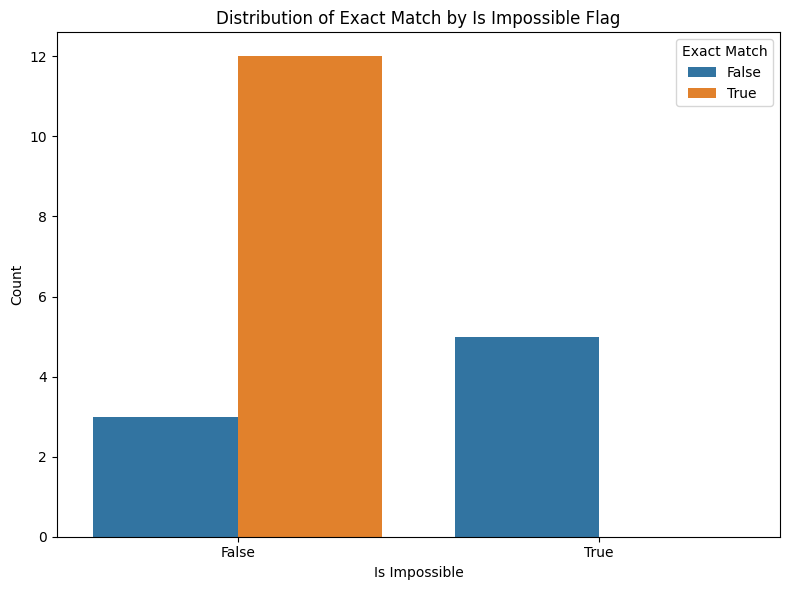

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Count combinations
count_df = df_detailed_eval.groupby(['is_impossible', 'is_exact_match']).size().reset_index(name='count')

# Plot as grouped bar
plt.figure(figsize=(8, 6))
sns.barplot(data=count_df, x='is_impossible', y='count', hue='is_exact_match')

plt.title('Distribution of Exact Match by Is Impossible Flag')
plt.xlabel('Is Impossible')
plt.ylabel('Count')
plt.legend(title='Exact Match')
plt.tight_layout()
plt.show()


# **Confusion Matrix–Style Bar Chart**

**Stacked Bar Chart**

Shows proportion of correct vs. incorrect answers within each is_impossible category.

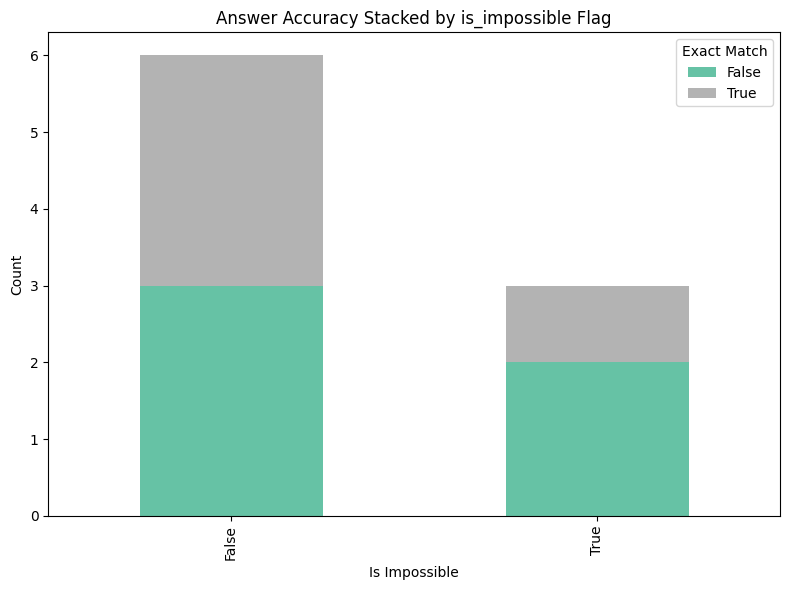

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Count combinations
df_counts = df_detailed_eval.groupby(['is_impossible', 'is_exact_match']).size().unstack().fillna(0)

# Plot
df_counts.plot(kind='bar', stacked=True, colormap='Set2', figsize=(8, 6))

plt.title('Answer Accuracy Stacked by is_impossible Flag')
plt.xlabel('Is Impossible')
plt.ylabel('Count')
plt.legend(title='Exact Match')
plt.tight_layout()
plt.show()

Confusion Matrix (if you convert prediction types)

If your predictions include multiple classes (like Correct Answer, Incorrect Answer, No Answer when required, etc.), you can plot a proper confusion matrix:

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define actual and predicted binary labels
# True = "Answer expected", False = "No answer expected"
_df_4['true_binary'] = _df_4['is_impossible'].apply(lambda x: 0 if x else 1)  # 0: No answer expected, 1: Answer expected
_df_4['pred_binary'] = _df_4['predicted_answer'].apply(lambda x: 0 if x.lower().strip() == "no answer" else 1)

# Create confusion matrix
cm = confusion_matrix(_df_4['true_binary'], _df_4['pred_binary'])

# Display with proper labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Answer', 'Has Answer'])
disp.plot(cmap='Purples')
plt.title("QA Confusion Matrix: True vs Predicted Answerability")
plt.show()


NameError: name '_df_4' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ✅ Binary mapping
_df_4['true_binary'] = _df_4['is_impossible'].apply(lambda x: 0 if x else 1)   # 1 = answer expected
_df_4['pred_binary'] = _df_4['predicted_answer'].apply(lambda x: 0 if x.strip().lower() == "no answer" else 1)

# ✅ Compute confusion matrix
cm = confusion_matrix(_df_4['true_binary'], _df_4['pred_binary'])
labels = ['No Answer Expected', 'Answer Expected']

# ✅ Create heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Purples',
            xticklabels=['Predicted: No Answer', 'Predicted: Has Answer'],
            yticklabels=['True: No Answer', 'True: Has Answer'])

plt.title('🔍 QA Answerability Confusion Matrix (Heatmap)')
plt.xlabel('Model Prediction')
plt.ylabel('Ground Truth')
plt.tight_layout()
plt.show()


NameError: name '_df_4' is not defined